In [17]:
import os
import glob
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TOGETHER_API_KEY"] = os.getenv("TOGETHER_API_KEY")
os.environ["MISTRAL_API_KEY"] = os.getenv("MISTRAL_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")

In [18]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"]=os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"]="true"
os.environ["LANGSMITH_PROJECT"]="RAG WITH LANGGRAPH"

In [19]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")

In [20]:
from langchain_mistralai.embeddings import MistralAIEmbeddings
embeddings = MistralAIEmbeddings(model="mistral-embed") 

d:\LangGraph\langgraph-handson\Lib\site-packages\langchain_mistralai\embeddings.py:186: UserWarning: Could not download mistral tokenizer from Huggingface for calculating batch sizes. Set a Huggingface token via the HF_TOKEN environment variable to download the real tokenizer. Falling back to a dummy tokenizer that uses `len()`.
  warnings.warn(


In [21]:
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.documents import Document

In [ ]:
all_text = ""
for file_path in glob.glob("Curie_Radiation_Documents/*.txt"):
    loader = TextLoader(file_path)
    docs = loader.load()
    for doc in docs:
        all_text += doc.page_content + "\n"

# Create a single Document object
combined_doc = Document(page_content=all_text)

# If you need it in a list format (e.g., for chains or vector stores)
docs = [combined_doc]

In [33]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(docs)
docs_string = [doc.page_content for doc in chunks]

In [34]:
vectorstore = Chroma.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [35]:
retriever.get_relevant_documents("What is the Curie radiation?")

C:\Users\abhes\AppData\Local\Temp\ipykernel_11128\7707427.py:1: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retriever.get_relevant_documents("What is the Curie radiation?")


[Document(metadata={}, page_content='The principles of radiation detection and shielding stem from early Curie experiments.\nNuclear power plants use radioactive decay for energy generation.\nRadiation science remains a critical part of modern technology and healthcare.\nMarie Curie kept detailed lab notebooks, many of which remain radioactive to this day.\nThese notes documented the complex processes used to isolate radium and polonium.\nHer scientific rigor and careful documentation helped future researchers build upon her work.'),
 Document(metadata={}, page_content='The principles of radiation detection and shielding stem from early Curie experiments.\nNuclear power plants use radioactive decay for energy generation.\nRadiation science remains a critical part of modern technology and healthcare.\nMarie Curie kept detailed lab notebooks, many of which remain radioactive to this day.\nThese notes documented the complex processes used to isolate radium and polonium.\nHer scientific ri

In [73]:
from typing_extensions import Annotated, List, TypedDict
from langchain_core.messages import AnyMessage 
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage] , add_messages]


In [74]:
def LLMChain(AgentState : State):
    message = AgentState["messages"]
    
    # Extract the content from the last message
    if isinstance(message[-1], str):
        question = message[-1]
    else:
        question = message[-1].content if hasattr(message[-1], 'content') else str(message[-1])
    
    complete_prompt = "Your Task is to provide the brief answer based on the user query \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState["messages"].append(response.content)
    
    return AgentState

In [75]:
def RAGChain(AgentState : State):
    message = AgentState["messages"]
    
    # Extract the first message (original question)
    if isinstance(message[0], str):
        question = message[0]
    else:
        question = message[0].content if hasattr(message[0], 'content') else str(message[0])
    
    template = """Answer the question based on the following context:
    {context}
    
    Question: {question} 
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    response = chain.invoke(question)
    
    # Add the RAG response to the messages
    AgentState["messages"].append(response)
    
    return AgentState

In [76]:
from langgraph.graph import StateGraph
graph = StateGraph(State)

graph.add_node("LLM", LLMChain)
graph.add_node("RAGTool", RAGChain)

graph.add_edge("LLM", "RAGTool")
graph.set_entry_point("LLM")
graph.set_finish_point("RAGTool")

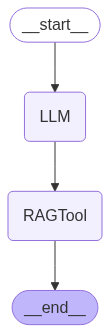

In [77]:
builder = graph.compile()
builder

In [78]:
from langchain_core.messages import HumanMessage
query = {"messages": [HumanMessage(content="What is the Curie radiation?")]}

for event in builder_new.stream(query):
    print(event)

{'LLM': {'messages': [HumanMessage(content='What is the Curie radiation?', additional_kwargs={}, response_metadata={}, id='846a1392-e362-4f05-912a-aa04999e3fd7'), 'Curie radiation is the emission of ionizing radiation from a radioactive substance.  \n']}}
{'RAGTool': {'messages': [HumanMessage(content='What is the Curie radiation?', additional_kwargs={}, response_metadata={}, id='846a1392-e362-4f05-912a-aa04999e3fd7'), HumanMessage(content='Curie radiation is the emission of ionizing radiation from a radioactive substance.  \n', additional_kwargs={}, response_metadata={}, id='b330ed03-99d6-4d57-ae81-4e6a170aeafd'), HumanMessage(content='Curie radiation is the emission of ionizing radiation from a radioactive substance.  \n', additional_kwargs={}, response_metadata={}, id='20bafde7-6448-4b5d-89ce-0c589ac0f224'), 'While the text mentions "early Curie experiments" and Marie Curie\'s work with radium and polonium, it doesn\'t explicitly define "Curie radiation."  \n\nWe can infer that "Cur

In [81]:
query = {"messages": [HumanMessage(content="Why did curie got nobel prize for?")]}

for event in builder_new.stream(query):
    print(event)

{'LLM': {'messages': [HumanMessage(content='Why did curie got nobel prize for?', additional_kwargs={}, response_metadata={}, id='6d135072-4763-4929-905e-12127e661592'), 'Marie Curie received the Nobel Prize in Physics in 1903 for her work on radioactivity, along with her husband Pierre Curie and Henri Becquerel.  \n']}}
{'RAGTool': {'messages': [HumanMessage(content='Why did curie got nobel prize for?', additional_kwargs={}, response_metadata={}, id='6d135072-4763-4929-905e-12127e661592'), HumanMessage(content='Marie Curie received the Nobel Prize in Physics in 1903 for her work on radioactivity, along with her husband Pierre Curie and Henri Becquerel.  \n', additional_kwargs={}, response_metadata={}, id='b4dd75b8-0bbb-421f-8b6e-5bbb187af844'), HumanMessage(content='Marie Curie received the Nobel Prize in Physics in 1903 for her work on radioactivity, along with her husband Pierre Curie and Henri Becquerel.  \n', additional_kwargs={}, response_metadata={}, id='bb1b80e2-431e-4e4c-a8a0-7